# Comparative Subject VAE

In [1]:
# !pip install torchinfo
import torch
import torch.nn as nn
from torchinfo import summary
import matplotlib.pyplot as plt
import os
import gc
# os.environ['OPENBLAS_NUM_THREADS'] = '1'
import numpy as np
import time
import CompMethods_V3 as TP
import DataSetting_v5 as DS

In [2]:
date = '20240917'
name = f'{date}_COMP_sub'
data_path = [
    '../dataset/Door_EXP/A208',
#'../dataset/Door_EXP/A308',
#'../dataset/Door_EXP/A308T',
#'../dataset/Door_EXP/B211',
# dataset/Door_EXP/C605_new'
]
level = 'subject'

data_organizer = DS.DataOrganizer(name, data_path, level)
data_organizer.load()

Cross validation plan at subject level
Loading ../dataset/Door_EXP/A208...

Loaded 0709A23-csi.npy of shape (111248, 30, 3)
Loaded 0709A41-csi.npy of shape (248817, 30, 3)
Loaded 0709A24-csi.npy of shape (38347, 30, 3)
Loaded 0709A20-csi.npy of shape (209993, 30, 3)
Loaded 0709A14-csi.npy of shape (168611, 30, 3)
Loaded 0709A12-csi.npy of shape (151822, 30, 3)
Loaded 0709A02-csi.npy of shape (232687, 30, 3)
Loaded 0709A11-csi.npy of shape (219643, 30, 3)
Loaded 0709A50-csi.npy of shape (133412, 30, 3)
Loaded 0709A511-csi.npy of shape (62914, 30, 3)
Loaded 20240709_153519-rimg.npy of shape (4057, 128, 226)
Loaded 20240709_154950-rimg.npy of shape (6302, 128, 226)
Loaded 20240709_161802-rimg.npy of shape (3442, 128, 226)
Loaded 20240709_185105-rimg.npy of shape (6481, 128, 226)
Loaded 20240709_192745-rimg.npy of shape (7787, 128, 226)
Loaded 20240709_193501-rimg.npy of shape (3267, 128, 226)
Loaded 20240709_191754-rimg.npy of shape (5395, 128, 226)
Loaded 20240709_163045-rimg.npy of shap

In [3]:
data_organizer.gen_plan(subset_ratio=0.2, save=True, notion='C605')

Saving plan subject @ 0.2...
Fetched level subject, 1 of 6, current = jiao
 Train set range = {'zhang', 'wang', 'higashinaka', 'qiao', 'chen'}, len = 8308 from 41543
 Test set current = jiao, len = 3288 from 16440
Fetched level subject, 2 of 6, current = zhang
 Train set range = {'jiao', 'wang', 'higashinaka', 'qiao', 'chen'}, len = 9843 from 49215
 Test set current = zhang, len = 1753 from 8768
Fetched level subject, 3 of 6, current = wang
 Train set range = {'jiao', 'zhang', 'higashinaka', 'qiao', 'chen'}, len = 10212 from 51061
 Test set current = wang, len = 1384 from 6922
Fetched level subject, 4 of 6, current = higashinaka
 Train set range = {'jiao', 'zhang', 'wang', 'qiao', 'chen'}, len = 9569 from 47845
 Test set current = higashinaka, len = 2027 from 10138
Fetched level subject, 5 of 6, current = qiao
 Train set range = {'jiao', 'zhang', 'wang', 'higashinaka', 'chen'}, len = 10065 from 50327
 Test set current = qiao, len = 1531 from 7656
Fetched level subject, 6 of 6, current 

### VAE

In [4]:
preprocess = DS.Preprocess(new_size=(128, 128))
data_organizer.load_plan('../dataset/Door_EXP/subject_r0.2.pkl')

def run(gpu):
    for i in range(6):
        data_organizer.gen_plan()
        train_loader, valid_loader, test_loader, current_test = data_organizer.gen_loaders(mode='s', num_workers=2)
        if current_test in ('higashinaka', 'jiao', 'zhang', 'qiao'):
            continue
        VAE_trainer = TP.CompTrainer(name='VAE', mode='vae', mask=False,
                                     networks=[TP.CSIEncoder(mode='vae', middle_dim=512*7*75, latent_dim=128), 
                                               TP.ImageDecoder(latent_dim=128)],
                                     lr=1e-4, epochs=10, cuda=gpu,
                                     preprocess = preprocess,
                                     loss_optimizer = {'LOSS': [torch.optim.Adam, 1e-4]},
                                     notion=f"{name}_{current_test}_VAE",
                                     train_loader=train_loader, valid_loader=valid_loader, test_loader=test_loader)
        vae_trained = VAE_trainer.schedule(early_stop=True, lr_decay=True)
        del vae_trained
        del VAE_trainer
        del test_loader
        torch.cuda.empty_cache()
        gc.collect()
        break

Loaded plan!


Generating loaders for s: level = subject, current test = higashinaka
 Train dataset length = 9503
 Test dataset length = 2027
 Exported train loader of len 118, batch size = 64
 Exported valid loader of len 29, batch size = 64
 Exported test loader of len 32, batch size = 1

Generating loaders for s: level = subject, current test = jiao
 Train dataset length = 8297
 Test dataset length = 3231
 Exported train loader of len 103, batch size = 64
 Exported valid loader of len 25, batch size = 64
 Exported test loader of len 51, batch size = 1

Generating loaders for s: level = subject, current test = zhang
 Train dataset length = 9786
 Test dataset length = 1740
 Exported train loader of len 122, batch size = 64
 Exported valid loader of len 30, batch size = 64
 Exported test loader of len 28, batch size = 1

Generating loaders for s: level = subject, current test = qiao
 Train dataset length = 10004
 Test dataset length = 1531
 Exported train loader of len 125, batch size = 64
 Exported 

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          |[00:00<?]

Training stopped due to Caught AttributeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 287, in _worker_loop
    data = fetcher.fetch(index)
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 49, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 49, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataset.py", line 363, in __getitem__
    return self.dataset[self.indices[idx]]
  File "/home/bob/datastore/Models/DataSetting_v5.py", line 116, in __getitem__
    ret['abs_ind'] = self.label.index[index].to_numpy()
AttributeError: 'numpy.int64' object has no attribute 'to_numpy'



IndexError: list index out of range

<Figure size 432x288 with 0 Axes>

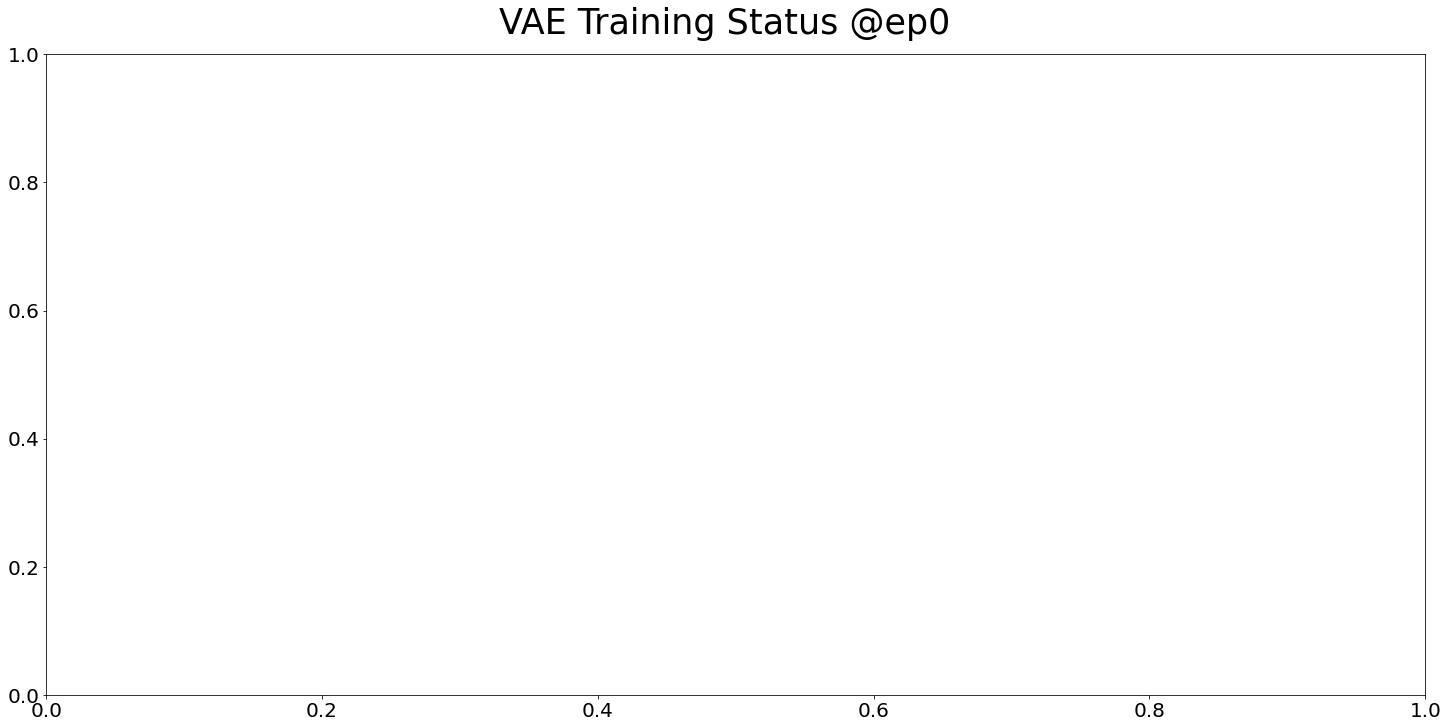

In [5]:
gpu = 3
torch.cuda.set_device(gpu)
run(gpu)